In [1]:
!pip install yfinance ta

     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 47.0 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=436ba5fd2040846fa183e9e1204f40544870511415ffc2114dd99d2fb7715d92
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium=

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import load_model
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import math

In [3]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Colab Notebooks/COMP5513'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/Colab Notebooks/COMP5513"


In [23]:
model = load_model('lstm-cnn.h5')
#model = load_model('lstm-cnn-20220310.h5')  #updated model

In [90]:
symbol = '2800.HK'#'AAPL'#'2800.HK'
stock = yf.Ticker(symbol)
df = stock.history(start="2020-12-31", end="2022-02-01")
#df = stock.history(start="2008-12-31", end="2022-12-31")#stock.history(period="max")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

In [91]:
indicator_bollinger = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
macd = MACD(close=stock_data["Close"])
rsi = RSIIndicator(close=stock_data["Close"])
ichi = IchimokuIndicator(high=stock_data["High"],low=stock_data["Low"])

#get the technical indicators
stock_data['macd'] = macd.macd()
stock_data['macd_signal'] = macd.macd_signal()
stock_data['rsi'] = rsi.rsi()
stock_data['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
stock_data['bollinger_hband'] = indicator_bollinger.bollinger_hband()
stock_data['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
stock_data['ichimoku_a'] = ichi.ichimoku_a()
stock_data['ichimoku_b'] = ichi.ichimoku_b()
stock_data['ichimoku_base_line'] = ichi.ichimoku_base_line()
stock_data['ichimoku_conversion_line'] = ichi.ichimoku_conversion_line()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data = stock_data.fillna(0)

#stock_data = stock_data[:-1]
stock_orig = stock_data.copy()

#stock = stock[250:]
stock_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line,SMA_10,SMA_30,SMA_50
Date,,,,,,,,,,,,,,,,,,
2020-12-31,27.440001,27.440001,27.440001,27.440001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.440001,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-04,27.360001,27.680000,27.320000,27.639999,228402605,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.500000,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-05,27.480000,27.879999,27.340000,27.740000,139782911,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.599999,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-06,27.799999,27.940001,27.580000,27.840000,145424037,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.630000,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-07,27.840000,27.920000,27.620001,27.700001,134972086,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.630000,0.000000,0.000000,0.000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,24.360001,24.520000,24.139999,24.400000,293789413,0.238102,0.130152,53.823723,24.009,25.261547,22.756453,24.290000,24.360000,23.970000,24.610001,24.570,23.796000,24.0784
2022-01-26,24.500000,24.620001,24.260000,24.400000,180807801,0.219607,0.148043,53.823723,24.069,25.274883,22.863116,24.300001,24.360000,23.990001,24.610001,24.560,23.817333,24.0504
2022-01-27,24.260000,24.260000,23.700001,23.920000,291671561,0.164324,0.151299,45.965314,24.101,25.254254,22.947746,24.200001,24.360000,23.990001,24.410001,24.496,23.828667,24.0132


In [92]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values

stock_data

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line,SMA_10,SMA_30,SMA_50
Date,,,,,,,,,,,,,,,,,,
2020-12-31,0.539380,0.519705,0.584810,0.544365,0.000000,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.605214,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,0.529833,0.549261,0.569620,0.568345,0.582183,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.616387,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,0.544153,0.573892,0.572152,0.580336,0.356297,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.635009,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-06,0.582339,0.581281,0.602532,0.592326,0.370676,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-07,0.587112,0.578818,0.607595,0.575540,0.344035,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,0.171838,0.160099,0.167089,0.179856,0.748850,0.704737,0.628666,0.556715,0.799580,0.803265,0.791290,0.804038,0.031657,0.800334,0.805828,0.803414,0.797079,0.815962
2022-01-26,0.188544,0.172414,0.182279,0.179856,0.460867,0.689633,0.645742,0.556715,0.801579,0.803689,0.794999,0.804369,0.031657,0.801002,0.805828,0.803087,0.797794,0.815014
2022-01-27,0.159905,0.128079,0.111393,0.122302,0.743452,0.644485,0.648850,0.475433,0.802644,0.803033,0.797942,0.801059,0.031657,0.801002,0.799280,0.800994,0.798173,0.813753


In [93]:
stock_data = stock_data.loc['2020-12-31':'2022-02-01']
stock_orig = stock_orig.loc['2020-12-31':'2022-02-01']

In [94]:
stock_final = stock_data.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line', 'SMA_10', 'SMA_30', 'SMA_50'],1)

features = 11 #including the close price

window_size = 60
week = 7
X = []
Y = []
for i in range(0 , len(stock_data) - window_size , 1):
  X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * features,1))
  Y.append(np.array(stock_data.iloc[i+window_size,3]).reshape(1,1))

test_X = np.array(X)
test_label = np.array(Y)
test_X = test_X.reshape(test_X.shape[0],features,window_size,1)

stock_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,High,Low,Close,macd,macd_signal,rsi,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line
Date,,,,,,,,,,,
2020-12-31,0.519705,0.584810,0.544365,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.605214,0.000000
2021-01-04,0.549261,0.569620,0.568345,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.616387,0.000000
2021-01-05,0.573892,0.572152,0.580336,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.635009,0.000000
2021-01-06,0.581281,0.602532,0.592326,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000
2021-01-07,0.578818,0.607595,0.575540,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,0.160099,0.167089,0.179856,0.704737,0.628666,0.556715,0.803265,0.791290,0.804038,0.031657,0.800334
2022-01-26,0.172414,0.182279,0.179856,0.689633,0.645742,0.556715,0.803689,0.794999,0.804369,0.031657,0.801002
2022-01-27,0.128079,0.111393,0.122302,0.644485,0.648850,0.475433,0.803033,0.797942,0.801059,0.031657,0.801002


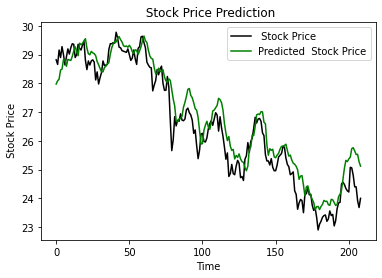

In [95]:
predicted  = model.predict(test_X)

real_price = stock_orig.iloc[window_size:,3].values
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)
plt.plot(real_price, color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()


In [96]:
testing_data = stock_orig.iloc[-len(predicted):,:]

In [132]:
def rsi_signal(rsi):
  rsi_val = float(rsi)
  if rsi_val >= 70:
    return -1
  if rsi_val <= 30:
    return 1
  else:
    return 0

def predict_signal(current, predict, threshold=0.01, bypass=False):
  diff = (current - predict)/current
  # print(diff)
  #if True:
  if abs(diff) >= threshold or bypass:
    if np.sign(diff) > 0:
      return -1
    else:
      return 1
  else:
    return 0

def sma_signal(curr_price, sma):
  if (curr_price > sma):
    return -1
  elif (curr_price < sma):
    return 1
  else:
    return 0

#moving average -> may test later
#all in/ all out Vs. 
def trade(price, capital, state, stock, rsi, macd, ml, bb, sma, trade_ratio, threshold=0.2, min_lot=500):
  remain = 0
  score = rsi*0.2+macd*0.2+bb*0.2+ml*0.2+sma*0.2
  #print(score)
  if score > threshold and state != 1:
    lots = math.floor(capital*trade_ratio / (price*min_lot))
    amount = price * lots * min_lot
    if lots > 1 and capital > amount:
      remain = capital - amount
    else:
      return None, None, None
    return remain, lots, 1
  elif score <= -0.2 and state != 0:
    values = capital + price * stock * min_lot
    return values, 0, 0
  else:
    return None, None, None

def macd_signal(macd, prev_macd, signal, prev_signal):
  if prev_signal > prev_macd and signal < macd:
    return 1
  elif prev_signal < prev_macd and signal > macd:
    return -1
  else:
    return 0

def bollinger_signal(prev_row, curr_row):
  if prev_row['Close'] < prev_row['bollinger_lbond'] and curr_row['Close'] > curr_row['bollinger_lbond']:
    return 1
  elif prev_row['Close'] > prev_row['bollinger_hband'] and curr_row['Close'] < curr_row['bollinger_hband']:
    return -1
  else:
    return 0

# All in trading strategy

In [133]:
money_sequence = []
count = 0
init_capital = 1000000
init_state = 0
init_stock = 0
cash_in_hand = init_capital
p_signal = 0
p_macd = 0
money_sequence.append(cash_in_hand)
for index, row in testing_data.iterrows():
  if count == 0:
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
    prev_r = row
    continue
  if count < len(predicted)-1:
    rsi_sig = rsi_signal(row['rsi'])
    ml_sig = predict_signal(row['Close'], predicted[count][0], bypass=True)
    macd_sig = macd_signal(row['macd'], p_macd, row['macd_signal'], p_signal)
    bollinger_sig = bollinger_signal(prev_r, row)
    sma_sig = sma_signal(row['Close'], row['SMA_50'])
    #print(rsi_sig, macd_sig, bollinger_sig, ml_sig, row['Close'], predicted[count][0])
    remain, lots, state = trade(row['Close'],cash_in_hand, init_state, init_stock, rsi_sig,macd_sig,ml_sig,bollinger_sig,sma_sig, trade_ratio=1)
    if (remain != None):
      cash_in_hand = remain
      init_state = state
      init_stock = lots
      print("Trading at: ", index, " long " if init_state == 1 else " short ", row['Close'], cash_in_hand, init_stock)
    if state == 0:
      money_sequence.append(remain)
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
  prev_r = row

if init_stock > 0:
  market_money = cash_in_hand+row['Close']*init_stock*500
  money_sequence.append(market_money)
money_sequence

Trading at:  2021-04-12 00:00:00  long  28.639999389648438 11920.021057128906 69
Trading at:  2021-05-25 00:00:00  short  29.18000030517578 1018630.0315856934 0
Trading at:  2021-06-16 00:00:00  long  28.799999237060547 10630.058288574219 70
Trading at:  2021-06-18 00:00:00  short  29.15999984741211 1031230.052947998 0
Trading at:  2021-06-21 00:00:00  long  28.860000610351562 6700.031280517578 71
Trading at:  2021-06-23 00:00:00  short  29.219999313354492 1044010.006904602 0
Trading at:  2021-07-05 00:00:00  long  28.639999389648438 12970.0288772583 72
Trading at:  2021-10-19 00:00:00  short  26.440000534057617 964810.0481033325 0
Trading at:  2021-10-29 00:00:00  long  25.520000457763672 7810.030937194824 75
Trading at:  2022-01-12 00:00:00  short  24.5 926560.0309371948 0
Trading at:  2022-01-27 00:00:00  long  23.920000076293945 5640.02799987793 77


[1000000,
 1018630.0315856934,
 1031230.052947998,
 1044010.006904602,
 964810.0481033325,
 926560.0309371948,
 929640.0279998779]

In [134]:
final_profit = money_sequence[-1]/init_capital - 1
print("final profit is ", final_profit*100,"%")

final profit is  -7.035997200012211 %


# Basic Kelly Trading Strategy

In [147]:
money_sequence_50 = []
count = 0
init_capital = 1000000
init_state = 0
init_stock = 0
cash_in_hand = init_capital
p_signal = 0
p_macd = 0
win_ratio = 0.5
profit_cnt = 0
no_of_trade = 0
money_sequence_50.append(cash_in_hand)
for index, row in testing_data.iterrows():
  if count == 0:
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
    prev_r = row
    continue
  if count < len(predicted)-1:
    rsi_sig = rsi_signal(row['rsi'])
    ml_sig = predict_signal(row['Close'], predicted[count][0])
    macd_sig = macd_signal(row['macd'], p_macd, row['macd_signal'], p_signal)
    bollinger_sig = bollinger_signal(prev_r, row)
    sma_sig = sma_signal(row['Close'], row['SMA_50'])
    #implement the basic Kelly Criterion
    if no_of_trade > 0:
      kelly_ratio = win_ratio - (1-win_ratio)/no_of_trade
    else:
      kelly_ratio = 0.5
    #print(rsi_sig, macd_sig, bollinger_sig, ml_sig, row['Close'], predicted[count][0])
    remain, lots, state = trade(row['Close'],cash_in_hand, init_state, init_stock, rsi_sig,macd_sig,ml_sig,bollinger_sig, sma_sig, trade_ratio=kelly_ratio)
    if (remain != None):
      cash_in_hand = remain
      init_state = state
      init_stock = lots
      print("Trading at: ", index, " long " if init_state == 1 else " short ", row['Close'], cash_in_hand, init_stock, kelly_ratio)
    if state == 0:
      no_of_trade += 1
      if money_sequence_50[-1] < remain:
        profit_cnt+=1
      win_ratio = profit_cnt/no_of_trade
      money_sequence_50.append(remain)
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
  prev_r = row

if init_stock > 0:
  market_money = cash_in_hand+row['Close']*init_stock*500
  money_sequence_50.append(market_money)
money_sequence_50

Trading at:  2021-04-21 00:00:00  long  28.899999618530273 508700.00648498535 34 0.5
Trading at:  2021-04-29 00:00:00  short  29.459999084472656 1009519.9909210205 0 0.5
Trading at:  2021-04-30 00:00:00  long  28.799999237060547 1520.0176239013672 70 1.0
Trading at:  2021-05-25 00:00:00  short  29.18000030517578 1022820.0283050537 0 1.0
Trading at:  2021-06-16 00:00:00  long  28.799999237060547 420.0553894042969 71 1.0
Trading at:  2021-06-18 00:00:00  short  29.15999984741211 1035600.0499725342 0 1.0
Trading at:  2021-06-21 00:00:00  long  28.860000610351562 11070.028305053711 71 1.0
Trading at:  2021-06-23 00:00:00  short  29.219999313354492 1048380.0039291382 0 1.0
Trading at:  2021-07-05 00:00:00  long  28.639999389648438 3020.026206970215 73 1.0
Trading at:  2021-10-18 00:00:00  short  26.100000381469727 955670.0401306152 0 1.0
Trading at:  2021-10-29 00:00:00  long  25.520000457763672 241110.02731323242 56 0.76
Trading at:  2021-11-17 00:00:00  short  25.780000686645508 962950.04

[1000000,
 1009519.9909210205,
 1022820.0283050537,
 1035600.0499725342,
 1048380.0039291382,
 955670.0401306152,
 962950.0465393066,
 935500.0581741333,
 937580.0561904907]

In [148]:
final_profit = money_sequence_50[-1]/init_capital - 1
print("final profit is ", final_profit*100,"%")

final profit is  -6.241994380950933 %


# Simulation Result Comparison

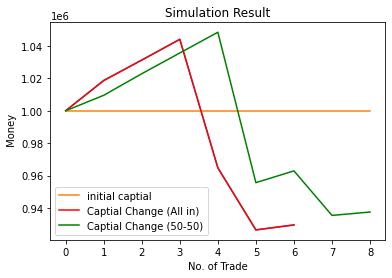

In [149]:
plt.plot(money_sequence)

x_coordinates = [i for i in range(len(money_sequence_50))]
y_coordinates = [1000000]*len(money_sequence_50)
plt.plot(x_coordinates, y_coordinates, label = 'initial captial')
plt.plot(money_sequence, color = 'red', label = 'Captial Change (All in)')
plt.plot(money_sequence_50, color = 'green', label = 'Captial Change (50-50)')
plt.title('Simulation Result')
plt.xlabel('No. of Trade')
plt.ylabel(' Money')
plt.legend()
plt.show()